## OPENBIB - Working with BigQuery

In [1]:
from google.cloud import bigquery
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
client = bigquery.Client(project='subugoe-collaborative')

In [3]:
openbib_inst = client.query(f"""
                            SELECT n_kb, n_oal, oal_ror, kb_ror, sector
                            FROM (
                                SELECT COUNT(DISTINCT(inst.doi)) AS n_kb, LOWER(kb_inst.ror) AS kb_ror, sector
                                FROM `subugoe-collaborative.openbib.kb_a_addr_inst` AS inst, UNNEST(kb_sector_id) AS sector
                                JOIN `subugoe-collaborative.openbib.kb_inst` AS kb_inst
                                  ON inst.kb_inst_id = kb_inst.kb_inst_id
                                JOIN `subugoe-collaborative.openalex.works` AS o
                                    ON inst.doi = o.doi
                                WHERE publication_year BETWEEN 2014 AND 2024
                                GROUP BY kb_ror, sector
                            ) AS kb
                            JOIN (
                              SELECT COUNT(DISTINCT(o.doi)) AS n_oal, LOWER(inst.ror) AS oal_ror
                              FROM `subugoe-collaborative.openalex.works` AS o, UNNEST(authorships) AS aut, UNNEST(aut.institutions) AS inst
                              WHERE inst.country_code = 'DE' AND publication_year BETWEEN 2014 AND 2024
                              GROUP BY oal_ror
                            ) AS oal
                              ON kb_ror = oal_ror
                            """).to_dataframe()

In [4]:
openbib_inst_plot = openbib_inst[openbib_inst.sector.isin(['uni', 'fh', 'hgf', 'fhg', 'mpg', 'wgl'])].copy()

openbib_inst_plot.replace(dict(
    uni='University',
    fh='Fachhochschule',
    mpg='Max Planck Society',
    hgf='Helmholtz Association',
    fhg='Fraunhofer Society',
    wgl='Leibniz Association'
), inplace=True)

openbib_inst_plot.sort_values(by=['sector'], ascending=False, inplace=True)

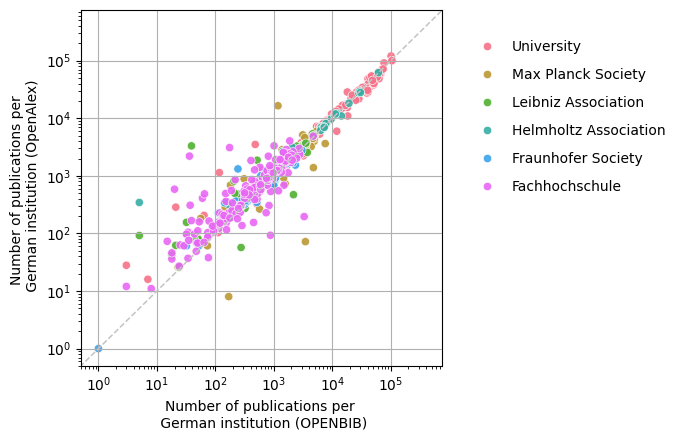

In [5]:
fig, ax = plt.subplots(figsize=(7, 4.5))

x = [x for x in range(-1000, 1000000, 10000)]
y = x

plt.grid(True)

sns.scatterplot(data=openbib_inst_plot,
                x='n_kb',
                y='n_oal',
                hue='sector',
                alpha=0.9,
                palette='husl')

sns.lineplot(x=x, 
             y=y, 
             color='#c3c3c3', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(2**-1, 15**5)
ax.set_ylim(2**-1, 15**5)

plt.xscale('log')
plt.yscale('log')

ax.set(xlabel='Number of publications per \n German institution (OPENBIB)', 
       ylabel='Number of publications per \n German institution (OpenAlex)')

ax.legend(bbox_to_anchor=(1.05, 0.95),
          frameon=False,
          labelspacing=1.0)

plt.tight_layout()
plt.show()
#fig.savefig('kb_institution_disambiguation.png', format='png', bbox_inches='tight', dpi=500)

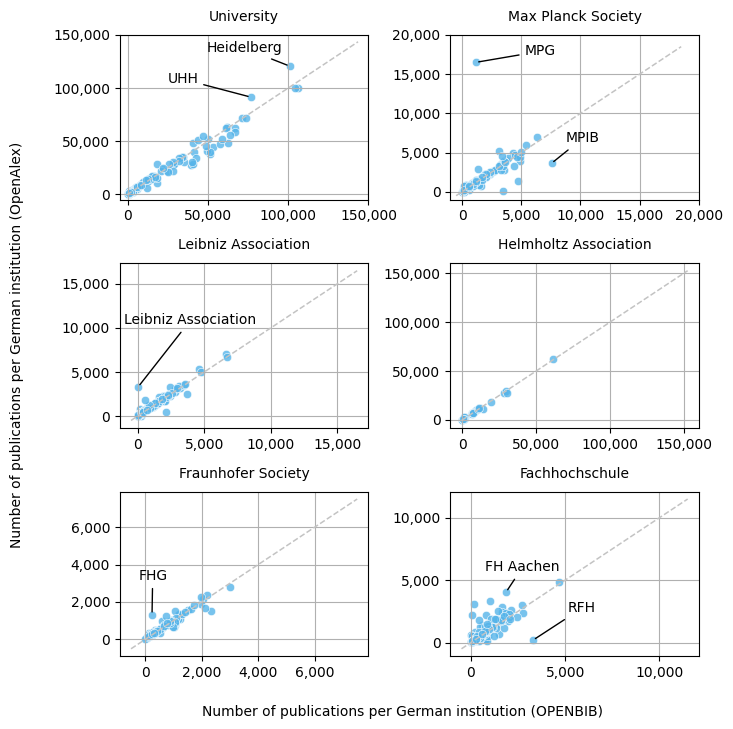

In [62]:
fig, axes = plt.subplots(nrows=3, 
                         ncols=2, 
                         sharex=False, 
                         sharey=False, 
                         figsize=(7,7))

axes = axes.reshape(-1)

for i, ax in enumerate(axes, 1):
    
    ax = plt.subplot(3,2,i) 

    sector = openbib_inst_plot.sector.unique()[i-1]

    t = 2.5
    
    if sector == 'University':
        t = 1.35

    x = [x for x in range(-500, int(openbib_inst_plot[openbib_inst_plot.sector == sector].n_kb.max() * t), 1000)]
    y = x

    plt.grid(True)
    
    sns.scatterplot(data=openbib_inst_plot[openbib_inst_plot.sector == sector],
                    x='n_kb',
                    y='n_oal',
                    color='#56B4E9',
                    alpha=0.8)

    sns.lineplot(x=x, 
                 y=y, 
                 color='#c3c3c3', 
                 linestyle='dashed', 
                 linewidth=1.1,
                 alpha=1)

    ax.set(xlabel=None, ylabel=None)

    if sector == 'University':
        ax.set_xlim(-5000, 150000)
        ax.set_ylim(-5000, 150000)

        plt.annotate('Heidelberg', (100852, 120646), xytext=(-60, 10), textcoords='offset points', arrowprops=dict(arrowstyle='-'))
        plt.annotate('UHH', (76626, 91473), xytext=(-60, 10), textcoords='offset points', arrowprops=dict(arrowstyle='-'))

    if sector == 'Max Planck Society':
        ax.set_xlim(-1000, 20000)
        ax.set_ylim(-1000, 20000)
        
        plt.annotate('MPG', (1175, 16502), xytext=(35, 5), textcoords='offset points', arrowprops=dict(arrowstyle='-'))
        plt.annotate('MPIB', (7557, 3632), xytext=(10, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-'))

    if sector == 'Leibniz Association':
        plt.annotate('Leibniz Association', (39, 3316), xytext=(-10, 45), textcoords='offset points', arrowprops=dict(arrowstyle='-'))

    if sector == 'Helmholtz Association':
        pass

    if sector == 'Fraunhofer Society':
        plt.annotate('FHG', (243, 1320), xytext=(-10, 25), textcoords='offset points', arrowprops=dict(arrowstyle='-'))

    if sector == 'Fachhochschule':
        plt.annotate('RFH', (3297, 196), xytext=(25, 20), textcoords='offset points', arrowprops=dict(arrowstyle='-'))
        plt.annotate('FH Aachen', (1869, 4049), xytext=(-15, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-'))

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    
    #plt.setp(ax.get_xticklabels()[::2], visible=False)
    #plt.setp(ax.get_yticklabels()[::2], visible=False)

    plt.title(sector, fontdict={'fontsize': 10, 'fontweight': 500}, pad=10)

plt.subplots_adjust(wspace=-0.4, hspace=0.4)

fig.text(0.52, -0.03, 'Number of publications per German institution (OPENBIB)', ha='center', 
         fontdict={'fontsize': 10, 'fontweight': 400})

fig.text(-0.04, 0.5, 'Number of publications per German institution (OpenAlex)', va='center', rotation='vertical', 
         fontdict={'fontsize': 10, 'fontweight': 400})

plt.tight_layout()
plt.show()

fig.savefig('kb_institution_disambiguation.png', format='png', bbox_inches='tight', dpi=600)

In [63]:
openbib_inst_plot[(openbib_inst_plot.sector == 'Leibniz Association') & (openbib_inst_plot.n_kb > 2000)]

,n_kb,n_oal,oal_ror,kb_ror,sector
850,2300,2328,https://ror.org/02skbsp27,https://ror.org/02skbsp27,Leibniz Association
1110,2023,2108,https://ror.org/018afyw53,https://ror.org/018afyw53,Leibniz Association
1343,3183,3216,https://ror.org/029hg0311,https://ror.org/029hg0311,Leibniz Association
1827,2106,2166,https://ror.org/055s37c97,https://ror.org/055s37c97,Leibniz Association
4,4589,5356,https://ror.org/04ews3245,https://ror.org/04ews3245,Leibniz Association
1440,2785,2703,https://ror.org/01amp2a31,https://ror.org/01amp2a31,Leibniz Association
1237,4780,5016,https://ror.org/04zb59n70,https://ror.org/04zb59n70,Leibniz Association
1042,2431,2222,https://ror.org/02f99v835,https://ror.org/02f99v835,Leibniz Association
1513,3448,3533,https://ror.org/01tspta37,https://ror.org/01tspta37,Leibniz Association
37,3104,3401,https://ror.org/0050vmv35,https://ror.org/0050vmv35,Leibniz Association


In [25]:
doc_sectors_df = client.query(f"""
                              SELECT COUNT(DISTINCT(dt.doi)) AS n, kb_inst_id AS institution, sector, is_research
                              FROM subugoe-collaborative.openbib.kb_a_addr_inst AS kb_a, UNNEST(kb_sector_id) AS sector
                              JOIN subugoe-collaborative.openbib.document_types AS dt
                                  ON LOWER(dt.doi) = LOWER(kb_a.doi)
                              GROUP BY sector, institution, is_research
                              """
                              ).to_dataframe()

/Users/najkojahn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [26]:
doc_sectors_df_is_research = doc_sectors_df[doc_sectors_df.is_research==True].groupby(['institution', 'sector'])['n'].sum().reset_index()
doc_sectors_df_all = doc_sectors_df.groupby(['institution', 'sector'])['n'].sum().reset_index()
doc_sectors_df_plot = doc_sectors_df_all.merge(doc_sectors_df_is_research, on=['institution', 'sector'], suffixes=('_all', '_is_research'))

In [27]:
doc_sectors_df_plot = doc_sectors_df_plot[doc_sectors_df_plot.sector.isin(['uni', 'wgl', 'hgf', 'fh', 'mpg', 'fhg'])]
doc_sectors_df_plot.replace(dict(
    uni='University',
    fh='Fachhochschule',
    mpg='Max Planck Society',
    hgf='Helmholtz Association',
    fhg='Fraunhofer Society',
    wgl='Leibniz Association'
), inplace=True)

doc_sectors_df_plot.sort_values(by=['sector'], ascending=False, inplace=True)

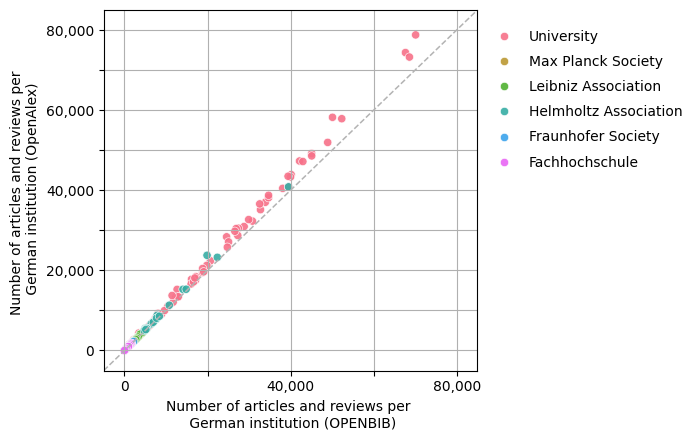

In [28]:
fig, ax = plt.subplots(figsize=(5, 4.5))

plt.grid(True)

x = [x for x in range(-5000, 90000, 5000)]
y = x    
    
sns.scatterplot(data=doc_sectors_df_plot, 
                x='n_is_research', 
                y='n_all',
                alpha=0.9,
                palette='husl',
                hue='sector')

sns.lineplot(x=x, 
             y=y, 
             color='#b3b3b3a0', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(-5000, 85000)
ax.set_ylim(-5000, 85000)

ax.get_legend().remove()

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.setp(ax.get_xticklabels()[::2], visible=False)
plt.setp(ax.get_yticklabels()[::2], visible=False)

ax.set(xlabel='Number of articles and reviews per \n German institution (OPENBIB)', 
       ylabel='Number of articles and reviews per \n German institution (OpenAlex)')

lgd = fig.legend(frameon=False, 
                 bbox_to_anchor=(1.4, 0.95),
                 labelspacing=0.8)

plt.tight_layout()
plt.show()
#fig.savefig('document_types_sectors.png', format='png', bbox_inches='tight', dpi=500)

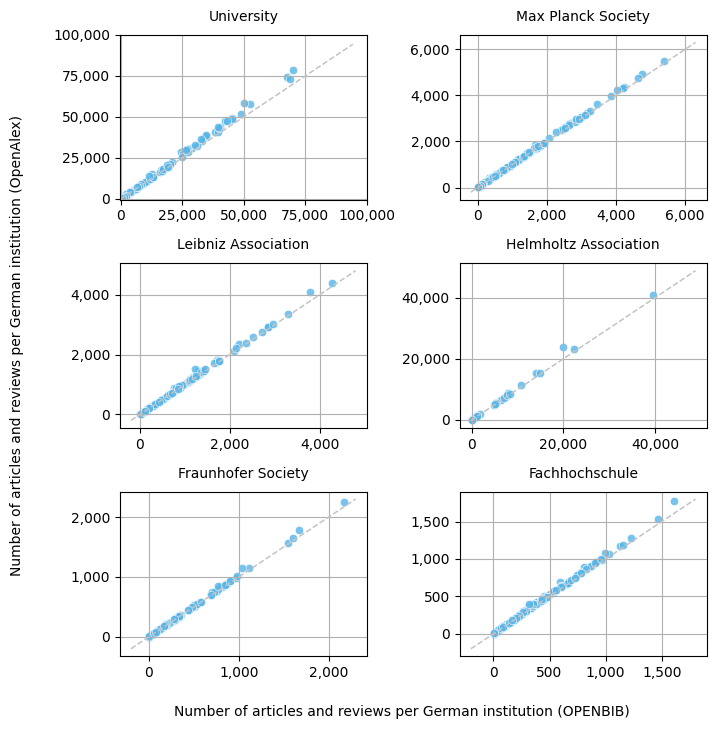

In [29]:
fig, axes = plt.subplots(nrows=3, 
                         ncols=2, 
                         sharex=False, 
                         sharey=False, 
                         figsize=(7,7))

axes = axes.reshape(-1)

for i, ax in enumerate(axes, 1):
    
    ax = plt.subplot(3,2,i) 

    sector = openbib_inst_plot.sector.unique()[i-1]

    x = [x for x in range(-200, int(doc_sectors_df_plot[doc_sectors_df_plot.sector == sector].n_all.max() * 1.2), 500)]
    y = x

    plt.grid(True)
    
    sns.scatterplot(data=doc_sectors_df_plot[doc_sectors_df_plot.sector == sector],
                    x='n_is_research',
                    y='n_all',
                    color='#56B4E9',
                    alpha=0.8)

    sns.lineplot(x=x, 
                 y=y, 
                 color='#c3c3c3', 
                 linestyle='dashed', 
                 linewidth=1.1,
                 alpha=1)

    ax.set(xlabel=None, ylabel=None)

    if sector == 'University':
        ax.set_xlim(-500, 100000)
        ax.set_ylim(-500, 100000)

    if sector == 'Max Planck Society':
        pass

    if sector == 'Leibniz Association':
        pass

    if sector == 'Helmholtz Association':
        pass

    if sector == 'Fraunhofer Society':
        pass

    if sector == 'Fachhochschule':
        pass

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    
    #plt.setp(ax.get_xticklabels()[::2], visible=False)
    #plt.setp(ax.get_yticklabels()[::2], visible=False)

    plt.title(sector, fontdict={'fontsize': 10, 'fontweight': 500}, pad=10)

plt.subplots_adjust(wspace=-0.4, hspace=0.4)

fig.text(0.52, -0.03, 'Number of articles and reviews per German institution (OPENBIB)', ha='center', 
         fontdict={'fontsize': 10, 'fontweight': 400})

fig.text(-0.04, 0.5, 'Number of articles and reviews per German institution (OpenAlex)', va='center', rotation='vertical', 
         fontdict={'fontsize': 10, 'fontweight': 400})

plt.tight_layout()
plt.show()

fig.savefig('document_types_sectors.png', format='png', bbox_inches='tight', dpi=600)

In [30]:
funders_sectors_df = client.query(f"""
                                  SELECT COUNT(DISTINCT(openbib_funding.doi)) AS f_n, 
                                         COUNT(DISTINCT(oal_funding.doi)) AS oal_n,
                                         institution, 
                                         sector
                                  FROM (
                                      SELECT f.doi
                                      FROM subugoe-collaborative.openbib.funding_information AS f
                                  ) AS openbib_funding
                                  LEFT JOIN (
                                      SELECT oal.doi
                                      FROM subugoe-collaborative.openalex.works AS oal, UNNEST(grants) AS grant
                                      JOIN subugoe-collaborative.openbib.funding_information AS f
                                          ON LOWER(f.doi) = LOWER(oal.doi)
                                      WHERE grant.funder_display_name = 'Deutsche Forschungsgemeinschaft'
                                  ) AS oal_funding
                                      ON LOWER(openbib_funding.doi) = LOWER(oal_funding.doi)
                                  JOIN (
                                    SELECT kb_a.doi AS kb_doi, kb_inst_id AS institution, sector
                                    FROM subugoe-collaborative.openbib.kb_a_addr_inst AS kb_a, UNNEST(kb_sector_id) AS sector  
                                    JOIN subugoe-collaborative.openbib.funding_information AS f
                                      ON LOWER(f.doi) = LOWER(kb_a.doi)
                                  ) AS kb_inst
                                      ON LOWER(openbib_funding.doi) = LOWER(kb_inst.kb_doi)
                                  GROUP BY institution, sector
                                  """
                                  ).to_dataframe()

/Users/najkojahn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [31]:
funders_sectors_df_plot = funders_sectors_df[funders_sectors_df.sector.isin(['uni', 'fh', 'hgf', 'fhg', 'mpg', 'wgl'])].copy()

funders_sectors_df_plot.replace(dict(
    uni='University',
    fh='Fachhochschule',
    mpg='Max Planck Society',
    hgf='Helmholtz Association',
    fhg='Fraunhofer Society',
    wgl='Leibniz Association'
), inplace=True)

funders_sectors_df_plot.sort_values(by=['sector'], ascending=False, inplace=True)

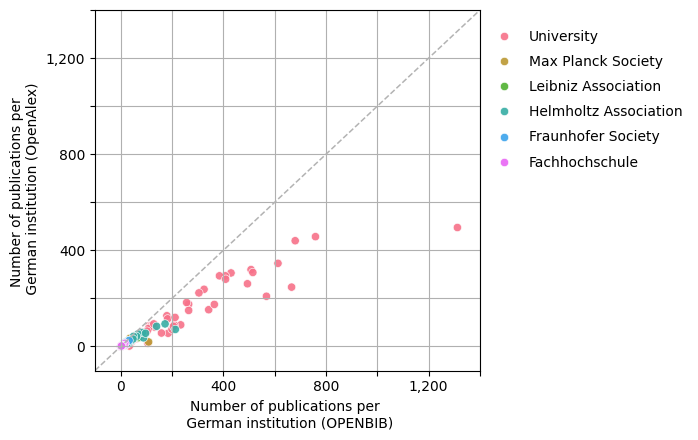

In [32]:
fig, ax = plt.subplots(figsize=(5, 4.5))

plt.grid(True)

x = [x for x in range(-100, 1500, 100)]
y = x    
    
sns.scatterplot(data=funders_sectors_df_plot, 
                x='f_n', 
                y='oal_n',
                alpha=0.9,
                palette='husl',
                hue='sector')

sns.lineplot(x=x, 
             y=y, 
             color='#b3b3b3a0', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(-100, 1400)
ax.set_ylim(-100, 1400)

ax.get_legend().remove()

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.setp(ax.get_xticklabels()[::2], visible=False)
plt.setp(ax.get_yticklabels()[::2], visible=False)

ax.set(xlabel='Number of publications per \n German institution (OPENBIB)', 
       ylabel='Number of publications per \n German institution (OpenAlex)')

lgd = fig.legend(frameon=False, 
                 bbox_to_anchor=(1.4, 0.95),
                 labelspacing=0.8)

plt.tight_layout()
plt.show()
#fig.savefig('funding_information_sectors.png', format='png', bbox_inches='tight', dpi=500)

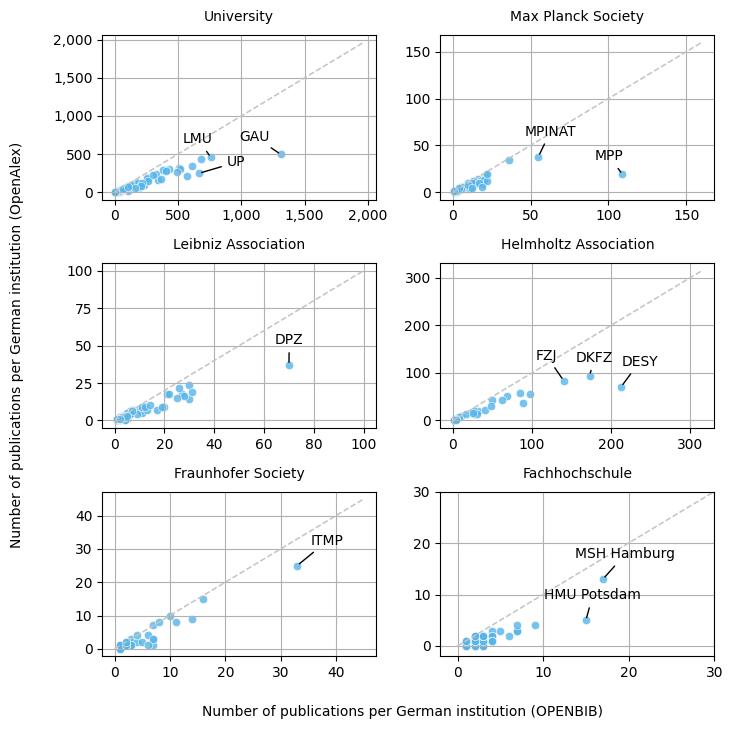

In [33]:
fig, axes = plt.subplots(nrows=3, 
                         ncols=2, 
                         sharex=False, 
                         sharey=False, 
                         figsize=(7,7))

axes = axes.reshape(-1)

for i, ax in enumerate(axes, 1):
    
    ax = plt.subplot(3,2,i) 

    sector = funders_sectors_df_plot.sector.unique()[i-1]

    if not sector == 'Fachhochschule':

        x = [x for x in range(0, int(funders_sectors_df_plot[funders_sectors_df_plot.sector == sector].f_n.max() * 1.5), 5)]

    else:
        x = [x for x in range(0, 50, 5)]

    y = x

    plt.grid(True)
    
    sns.scatterplot(data=funders_sectors_df_plot[funders_sectors_df_plot.sector == sector],
                    x='f_n',
                    y='oal_n',
                    color='#56B4E9',
                    alpha=0.8)

    sns.lineplot(x=x, 
                 y=y, 
                 color='#c3c3c3', 
                 linestyle='dashed', 
                 linewidth=1.1,
                 alpha=1)

    ax.set(xlabel=None, ylabel=None)

    if sector == 'University':
        plt.annotate('GAU', (1312, 495), xytext=(-30, 10), textcoords='offset points', arrowprops=dict(arrowstyle='-'))
        plt.annotate('LMU', (759, 457), xytext=(-20, 10), textcoords='offset points', arrowprops=dict(arrowstyle='-'))
        plt.annotate('UP', (666, 247), xytext=(20, 5), textcoords='offset points', arrowprops=dict(arrowstyle='-'))

    if sector == 'Max Planck Society':
        plt.annotate('MPP', (109, 19), xytext=(-20, 10), textcoords='offset points', arrowprops=dict(arrowstyle='-'))
        plt.annotate('MPINAT', (55, 38), xytext=(-10, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-'))

    if sector == 'Leibniz Association':
        plt.annotate('DPZ', (70, 37), xytext=(-10, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-'))

    if sector == 'Helmholtz Association':
        plt.annotate('DKFZ', (173, 94), xytext=(-10, 10), textcoords='offset points', arrowprops=dict(arrowstyle='-'))
        plt.annotate('DESY', (213, 71), xytext=(0, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-'))
        plt.annotate('FZJ', (140, 84), xytext=(-20, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-'))

    if sector == 'Fraunhofer Society':
        plt.annotate('ITMP', (33, 25), xytext=(10, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-'))

    if sector == 'Fachhochschule':
        ax.set_xlim(-2, 30)
        ax.set_ylim(-2, 30)
        plt.annotate('HMU Potsdam', (15, 5), xytext=(-30, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-'))
        plt.annotate('MSH Hamburg', (17, 13), xytext=(-20, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-'))

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    
    #plt.setp(ax.get_xticklabels()[::2], visible=False)
    #plt.setp(ax.get_yticklabels()[::2], visible=False)

    plt.title(sector, fontdict={'fontsize': 10, 'fontweight': 500}, pad=10)

plt.subplots_adjust(wspace=0.5, hspace=0.4)

fig.text(0.52, -0.03, 'Number of publications per German institution (OPENBIB)', ha='center', 
         fontdict={'fontsize': 10, 'fontweight': 400})

fig.text(-0.04, 0.5, 'Number of publications per German institution (OpenAlex)', va='center', rotation='vertical', 
         fontdict={'fontsize': 10, 'fontweight': 400})

plt.tight_layout()
plt.show()

fig.savefig('funding_information_sectors.png', format='png', bbox_inches='tight', dpi=600)

In [34]:
funders_sectors_df_plot[(funders_sectors_df_plot.sector == 'Fachhochschule') & (funders_sectors_df_plot.f_n > 10)]

,f_n,oal_n,institution,sector
530,17,13,5628,Fachhochschule
506,15,5,5879,Fachhochschule
